# PythonCode Dataset

We se the dataset from https://huggingface.co/datasets/ajibawa-2023/Python-Code-23k-ShareGPT/tree/main 

In [5]:
import json
import numpy as np
import torch
from transformers import AutoTokenizer

import os 
import sys

sys.path.append(os.path.join(os.getcwd(), "../../"))

import src.visualization.plot_rawdata as plotutils

In [6]:
SHAREGPT_PATH = "../raw_instruct/Python-Code-23k-ShareGPT.json"
# Open the JSON file
with open(SHAREGPT_PATH, 'r') as file:
    data = json.load(file)  # Load the JSON data into a Python dictionary

In [7]:
print(f"Type of data: {type(data)}\nNumber of entries: {len(data)}")

Type of data: <class 'list'>
Number of entries: 22608


In [8]:
data[0]

{'id': '0',
 'conversations': [{'from': 'human',
   'value': 'Create a nested loop to print every combination of numbers between 0-9, excluding any combination that contains the number 5. Additionally, exclude any combination that contains a repeating digit. Implement the solution without using any built-in functions or libraries to check for repeating digits.'},
  {'from': 'gpt',
   'value': 'Here is an example of a nested loop in Python to print every combination of numbers between 0-9, excluding any combination that contains the number 5 or repeating digits:\n\n```python\nfor i in range(10):  # First digit\n    for j in range(10):  # Second digit\n        for k in range(10):  # Third digit\n            # Checking for the conditions\n            if i != 5 and j != 5 and k != 5 and i != j and i != k and j != k:\n                print(i, j, k)\n```\n\nThis code will generate and print every combination of three digits between 0-9 that do not contain the number 5 and do not have any rep

In [12]:
cached_elem = None
for i, elem in enumerate(data):
    if elem['id'] == '18058':
        cached_elem = elem
        break

In [13]:
cached_elem

{'id': '18058',
 'conversations': [{'from': 'human',
   'value': 'Can you extend the given Python code to include more abbreviations and their full names that you might be familiar with? Also, can you modify the code to print the abbreviations and their full names in alphabetical order?'},
  {'from': 'gpt',
   'value': 'Yes, I can do that. Here\'s an updated code that includes more abbreviations and prints them in alphabetical order:\r\n\r\n```python\r\nabbreviations = {\r\n    "AFK": "Away From Keyboard",\r\n    "ASAP": "As Soon As Possible",\r\n    "BFF": "Best Friends Forever",\r\n    "BTW": "By The Way",\r\n    "DIY": "Do It Yourself",\r\n    "ETA": "Estimated Time of Arrival",\r\n    "FYI": "For Your Information",\r\n    "IDK": "I Don\'t Know",\r\n    "IMO": "In My Opinion",\r\n    "IRL": "In Real Life",\r\n    "JK": "Just Kidding",\r\n    "LMAO": "Laughing My Ass Off",\r\n    "LOL": "Laugh Out Loud",\r\n    "NP": "No Problem",\r\n    "OMG": "Oh My God",\r\n    "ROFL": "Rolling On

In [15]:
data[i-1]

{'id': '18057',
 'conversations': [{'from': 'human',
   'value': "How can you modify the Joke class so that not only each animal is ridden by only one kid, but also the kid chooses the animal randomly without repetition? Furthermore, how can you incorporate the requirement that each kid can only ride a specific animal according to a table that lists the animal name, the corresponding kid's name, and the color of the animal? This table is provided below:\r\n\r\n```\r\n|   Animal     |   Kid Name   |   Animal Color    |\r\n|--------------|--------------|------------------|\r\n|     Cat      |     John     |       White      |\r\n|     Dog      |     Jane     |       Brown      |\r\n|     Cow      |     Tom      |       Black      |\r\n```\r\n\r\nTo avoid any confusion, each kid should only ride the animal that is assigned to him or her in the table. It is also important that no kid repeats riding the same animal twice. Can you make the necessary changes to the Joke class to meet these re

### No data
Check if there are elements with no conversations

In [8]:
no_conver_data = []

for elem in data: 
    if not len(elem['conversations']):
        no_conver_data.append(elem)

In [9]:
len(no_conver_data)


0

In [11]:
del no_conver_data

#### Only samples starting with 'human'
we do not want to bias the LLMs with ChatGPT-produced content.

In [12]:
data_humanstart = list()
for elem in data:
    if len(elem['conversations']) and elem['conversations'][0]['from']=="human":
        data_humanstart.append(elem)

In [13]:
len(data_humanstart)

22608

All converstaions start with human!

In [14]:
del data_humanstart

#### Plot conversations lengths (by human-GPT interactions)

In [17]:
conv_len = [len(elem['conversations']) for elem in data]
len(conv_len)

22608

In [16]:
set(conv_len)

{2}

All conversations START with HUMAN and are only ONE interaction long. 

#### Plot conversations lengths (number of tokens of first human input)

In [18]:
access_tk = os.getenv("HF_API_TOKEN")
device_str = "cuda:0"
model_name = "google/gemma-2-2b-it"
padding_side='left'

tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_tk, device_map=device_str, torch_dtype=torch.float16, padding_side=padding_side)



In [20]:
def get_tokens(sentence, tokenizer):
    return tokenizer.apply_chat_template(sentence, return_tensors="pt", add_generation_prompt=True)   

In [21]:
print(tokenizer.batch_decode(get_tokens([{'role': "user", 
             "content": data[0]['conversations'][0]['value']}], tokenizer))[0])

<bos><start_of_turn>user
Create a nested loop to print every combination of numbers between 0-9, excluding any combination that contains the number 5. Additionally, exclude any combination that contains a repeating digit. Implement the solution without using any built-in functions or libraries to check for repeating digits.<end_of_turn>
<start_of_turn>model



In [24]:
get_tokens([{'role': "user", 
             "content": data[0]['conversations'][0]['value']}], tokenizer).shape

torch.Size([1, 64])

#### Do the above for all conversations that start with human

In [27]:
conv_len_tokens = [get_tokens([{'role': "user", 
                                "content": elem['conversations'][0]['value']}], tokenizer).shape[1] 
                   for elem in data]

In [28]:
len(conv_len_tokens)

22608

In [33]:
np.max(conv_len_tokens)

1531

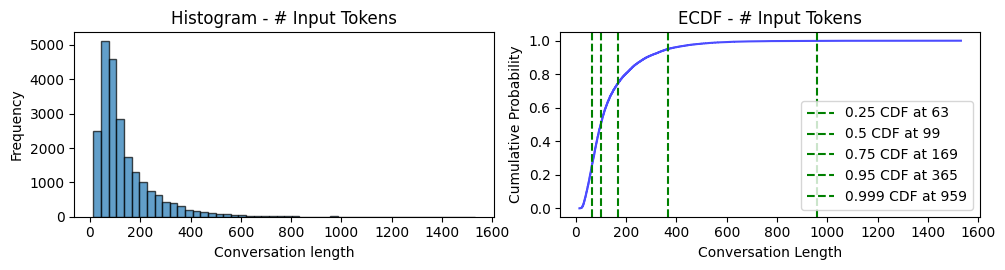

In [34]:
fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(10, 2.8), 
                                       in_title="# Input Tokens", 
                                       x_forcdf=0, cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.999])

In [35]:
fig.savefig("../../outputs/images/raw_data_PythonCode_ntokens_hist.pdf", bbox_inches="tight")

# Split the datasets

In [37]:
tmp = np.arange(len(data))
np.random.shuffle(tmp)

In [38]:
train_indxs, val_indxs, test_indxs = np.split(tmp, [int(0.7*len(tmp)), int(0.9*len(tmp))])

In [39]:
data_train = [data[i] for i in train_indxs]
data_val = [data[i] for i in val_indxs]
data_test = [data[i] for i in test_indxs]

In [41]:
# Check if the lengths agree
print(f"Percentage of training data: {round(len(data_train)/len(data), 4)}")
print(f"Percentage of validation data: {round(len(data_val)/len(data), 4)}")
print(f"Percentage of test data: {round(len(data_test)/len(data), 4)}")

Percentage of training data: 0.7
Percentage of validation data: 0.2
Percentage of test data: 0.1


In [42]:
def save_data(dataset, path):
    with open(path, 'w') as f:
        json.dump(dataset, f)
    print(f"Dataset saved to path {path}")

In [43]:
save_data(data_train, "../raw_instruct/PythonCode/raw_PythonCode_train.json")

Dataset saved to path ./data/raw_instruct/PythonCode/raw_PythonCode_train.json


In [44]:
save_data(data_val, "../raw_instruct/PythonCode/raw_PythonCode_validate.json")

Dataset saved to path ./data/raw_instruct/PythonCode/raw_PythonCode_validate.json


In [45]:
save_data(data_test, "../raw_instruct/PythonCode/raw_PythonCode_test.json")

Dataset saved to path ./data/raw_instruct/PythonCode/raw_PythonCode_test.json
